# Veri Madenciliğine Giriş Dersi Dönem Ödevi

## Kredi Kartı Dolandırıcılığı Tespiti Veri Kümesi Üzerinde KNN, Random Forest ve Decision Tree Algoritmalarının Uygulanması

### 170201067 - Kamer Koçak

### Veri Kümesi : https://www.kaggle.com/mlg-ulb/creditcardfraud



Öncelikle kullanacağımız kütüphaneleri import edelim.

In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)  
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import random

Grafik olarak çıktısını vereceğimiz sonuçlar için random renk seçen bir kod parçası ekleyelim.

In [150]:
def random_colors(number_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return color

Veri kümesini bulunduğu konumdan import edelim. 

In [151]:
train = pd.read_csv("/home/kamerkocak/Desktop/vmp/creditcard.csv")

In [152]:
table = ff.create_table(train.head().round(1)) #head default olarak ilk 5 satırı return edecek
iplot(table,filename='tablo1') #iplot yakınlaştırılabilir özellikli tablo oluşturdu
#‘Class’ özelliği yanıt değişkenidir ve dolandırıcılık durumunda 1, aksi takdirde 0 değerini alır.


In [153]:
train.columns #sütunlarının ve veri tiplerinin neler olduğunu öğrenelim

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [154]:
train.shape #satır ve sütun sayısını öğrenelim

(284807, 31)

In [155]:
iplot(ff.create_table(train.dtypes.to_frame().reset_index().round(3)),filename='tablo2')

In [156]:
train.describe().reset_index().round(1) #describe() metodu sayısal verilere sahip olan sütunların max, min , std…gibi istatiksel değerlerini döndürür

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,...,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
1,mean,94813.9,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,88.3,0.0
2,std,47488.1,2.0,1.7,1.5,1.4,1.4,1.3,1.2,1.2,...,0.7,0.7,0.6,0.6,0.5,0.5,0.4,0.3,250.1,0.0
3,min,0.0,-56.4,-72.7,-48.3,-5.7,-113.7,-26.2,-43.6,-73.2,...,-34.8,-10.9,-44.8,-2.8,-10.3,-2.6,-22.6,-15.4,0.0,0.0
4,25%,54201.5,-0.9,-0.6,-0.9,-0.8,-0.7,-0.8,-0.6,-0.2,...,-0.2,-0.5,-0.2,-0.4,-0.3,-0.3,-0.1,-0.1,5.6,0.0
5,50%,84692.0,0.0,0.1,0.2,-0.0,-0.1,-0.3,0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.1,0.0,0.0,22.0,0.0
6,75%,139320.5,1.3,0.8,1.0,0.7,0.6,0.4,0.6,0.3,...,0.2,0.5,0.1,0.4,0.4,0.2,0.1,0.1,77.2,0.0
7,max,172792.0,2.5,22.1,9.4,16.9,34.8,73.3,120.6,20.0,...,27.2,10.5,22.5,4.6,7.5,3.5,31.6,33.8,25691.2,1.0


## Eksik değer analizi

In [157]:
train.isnull().sum() # eksik değerlerin sayısını öğrenelim

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<AxesSubplot:>

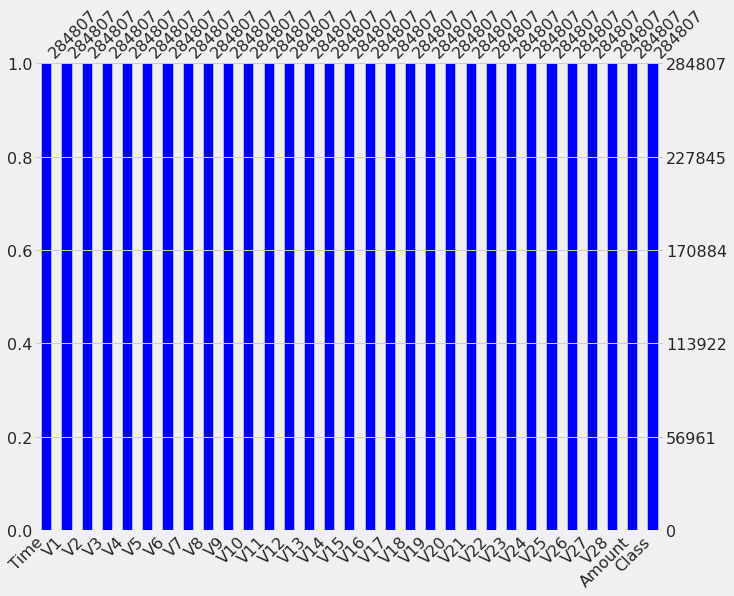

In [158]:
msno.bar(train, color = 'b', figsize = (10,8)) #msno.bar çizdirdik bir de bu şekliyle değişkenlerdeki missing value'larımızı gördük.

In [159]:
#msno.matrix(train) #msno.matrix bastırdık ve eksik veri pattern'lerini keşfettik

## Hedef değişken analizi

In [160]:
trace = go.Pie(labels = list(train.Class.unique()), values = list(train.Class.value_counts()),
                            hole = 0.2,
               marker=dict(colors = random_colors(3), 
                           line=dict(color='#000000', width=2)
                           ))
data = [trace]
layout = go.Layout(
   {
      "title": "Dolandırıcı vs Dolandırıcı Olmayan",
   }
)

fig = go.Figure(data=data,layout = layout)
iplot(fig)

## Veri İşleme ve Hazırlama

In [161]:
X = train.iloc[:,:-1].values
y = train.iloc[:,-1].values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Veri kümesini training set ve test setine bölme
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

<a id="5.2"></a>
<font color="purple" size=+2.5><b> K-Nearest Neighbours </b></font>


In [162]:
Model = KNeighborsClassifier(n_neighbors=8)
Model.fit(X_train, y_train)

y_pred = Model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Gerçek değerle tahmin arasındaki benzerliğe göre accuracy hesaplama.
knn_acc=accuracy_score(y_pred,y_test)
print('accuracy is',knn_acc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       1.00      0.01      0.01       136

    accuracy                           1.00     85443
   macro avg       1.00      0.50      0.51     85443
weighted avg       1.00      1.00      1.00     85443

[[85307     0]
 [  135     1]]
accuracy is 0.9984199992977775


<a id="5.21"></a>
<font color="purple" size=+2.5><b> Random Forest </b></font>



In [163]:
Model = RandomForestClassifier(n_estimators=100, max_features=3)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Gerçek değerle tahmin arasındaki benzerliğe göre accuracy hesaplama.
rf_acc=accuracy_score(y_pred,y_test)
print('accuracy is',rf_acc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.78      0.85       136

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443

[[85300     7]
 [   30   106]]
accuracy is 0.9995669627705019


<a id="5.3"></a>
<font color="purple" size=+2.5><b> Decision Tree </b></font>



In [164]:
Model = DecisionTreeClassifier()
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Gerçek değerle tahmin arasındaki benzerliğe göre accuracy hesaplama.
dt_acc=accuracy_score(y_pred,y_test)
print('accuracy is',dt_acc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.74      0.77      0.76       136

    accuracy                           1.00     85443
   macro avg       0.87      0.89      0.88     85443
weighted avg       1.00      1.00      1.00     85443

[[85270    37]
 [   31   105]]
accuracy is 0.999204147794436


In [165]:
print(knn_acc,"     ",rf_acc,"     ",dt_acc)

0.9984199992977775       0.9995669627705019       0.999204147794436


In [167]:
sonuc = {
	'KNN          ': knn_acc,
	'Random Forest': rf_acc,
	'Decision Tree': dt_acc
}

sirala_sonuc = sorted(sonuc.items(), key=lambda x: x[1], reverse=True)

for i in sirala_sonuc:
	print(i[0], i[1])

Random Forest 0.9995669627705019
Decision Tree 0.999204147794436
KNN           0.9984199992977775
